### SET PARAMETERS

In [1]:
from pathlib import Path

# DATA SETTINGS
TRAIN_PATH = Path('data/vids/split/train')
TEST_PATH = Path('data/vids/split/test')
IMG_SIZE = 256


# MESONET MODEL
# IF USING FrameGenerator
FRAMES_PER_VIDEO_MESO = 100

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO_MESO = 10
FRAMES_PER_SAMPLE_MESO = 10



# MOUTHNET MODEL
# IF USING FrameGenerator
FRAMES_PER_VIDEO_MOUTH = 20

# IF USING SamplingFrameGenerator
SAMPLES_PER_VIDEO_MOUTH = 2
FRAMES_PER_SAMPLE_MOUTH = 10


#BOTH
# TRAINING SETTINGS
EPOCHS_MESO = 10
EPOCHS_MOUTH = 5
BATCH_SIZE = 10

### LOAD MESONET DATA (Sampling Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = SamplingFrameGenerator(TRAIN_PATH, SAMPLES_PER_VIDEO_MESO, FRAMES_PER_SAMPLE_MESO, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO_MESO, FRAMES_PER_SAMPLE_MESO, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))


train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (100, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (100, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN (Mesonet Model)

In [3]:
from src.models import get_mesonet_model
from src.helpers import save_history
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mesonet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MESONET_SampleFrame"

# TRAIN MODEL

# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MESO,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
    219/Unknown 847s 4s/step - accuracy: 0.5436 - loss: 0.7688

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1070s 5s/step - accuracy: 0.5437 - loss: 0.7685 - val_accuracy: 0.5015 - val_loss: 0.6791
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 28893s 133s/step - accuracy: 0.7219 - loss: 0.6080 - val_accuracy: 0.6925 - val_loss: 0.6143
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 658s 3s/step - accuracy: 0.7723 - loss: 0.5097 - val_accuracy: 0.7692 - val_loss: 0.4955
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.8390 - loss: 0.3988 - val_accuracy: 0.7862 - val_loss: 0.4635
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.8317 - loss: 0.4192 - val_accuracy: 0.7897 - val_loss: 0.4821
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.7725 - loss: 0.4596 - val_accuracy: 0.8568 - val_loss: 0.3672
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.8543 - loss: 0.3489 - val_accuracy: 0.8360 - val_loss: 0.3716
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.8794 - loss: 0.2850 - val_accuracy: 

### VISUALIZE TRAINING HISTORY

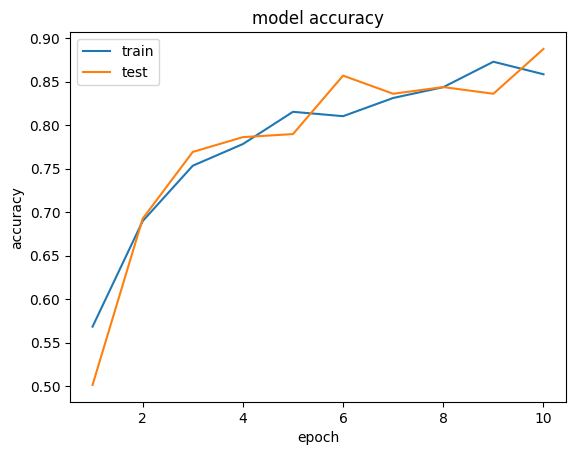

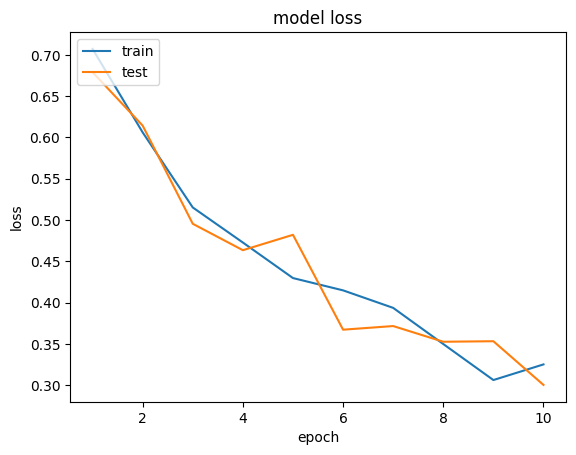

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MESO + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MESO + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MESO + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MESO + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LOAD MOUTHNET DATA (Sampling Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import SamplingFrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = SamplingFrameGenerator(TRAIN_PATH, SAMPLES_PER_VIDEO_MOUTH, FRAMES_PER_SAMPLE_MOUTH, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = SamplingFrameGenerator(TEST_PATH, SAMPLES_PER_VIDEO_MOUTH, FRAMES_PER_SAMPLE_MOUTH, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))


train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (20, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (20, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mouthnet Model)

In [3]:
from src.models import get_mouthnet_model
from src.helpers import save_history
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mouthnet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MOUTHNET_SampleFrame"

# INITIALIZE OPTIMIZER
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9, weight_decay=lr / EPOCHS_MOUTH)

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MOUTH,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,414,881 (234.28 MB)

 Trainable params: 61,354,337 (234.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/5
    219/Unknown 1064s 5s/step - accuracy: 0.4521 - loss: 0.7713

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1148s 5s/step - accuracy: 0.4524 - loss: 0.7713 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1115s 5s/step - accuracy: 0.4727 - loss: 0.7819 - val_accuracy: 0.5000 - val_loss: 0.7189
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1115s 5s/step - accuracy: 0.4748 - loss: 0.7983 - val_accuracy: 0.5000 - val_loss: 0.8688
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1120s 5s/step - accuracy: 0.5076 - loss: 0.9337 - val_accuracy: 0.5000 - val_loss: 0.9362
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1100s 5s/step - accuracy: 0.4795 - loss: 0.8897 - val_accuracy: 0.5000 - val_loss: 0.7379
TOTAL TRAIN TIME: 5598.287550400011


### VISUALIZE TRAINING HISTORY

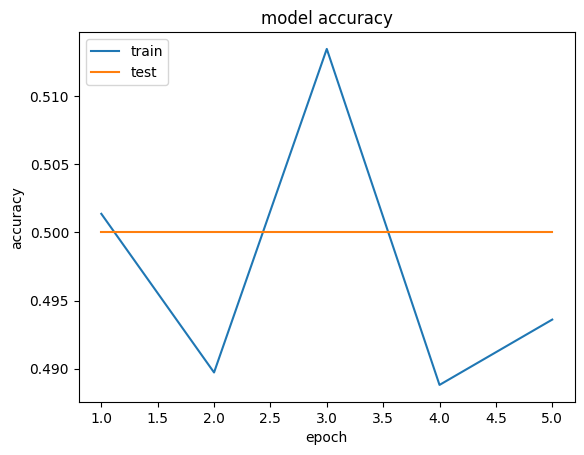

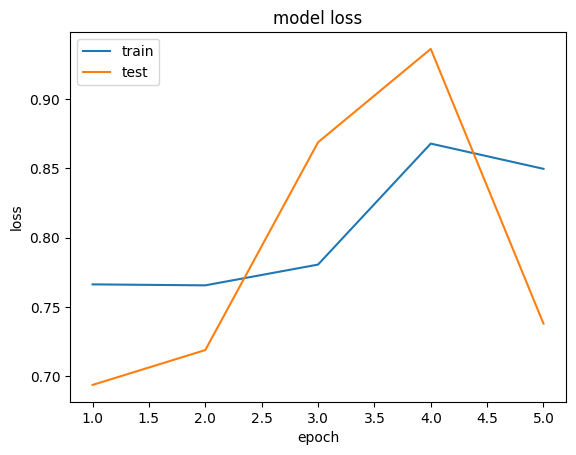

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MOUTH + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MOUTH + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LOAD DATA MESONET (Regular Frame Generator)

In [2]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO_MESO, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO_MESO, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (100, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (100, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mesonet Model)

In [3]:
from src.models import get_mesonet_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from time import perf_counter
from src.helpers import save_history

# LOAD NEW MODEL
model = get_mesonet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MESONET_RegularFrame"

# TRAIN MODEL

# INITIALIZE OPTIMIZER
optimizer = Adam()

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MESO,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
    219/Unknown 479s 2s/step - accuracy: 0.5514 - loss: 0.7325

c:\CS5100\deepfake-detection\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.5517 - loss: 0.7322 - val_accuracy: 0.5000 - val_loss: 0.6720
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.7563 - loss: 0.5353 - val_accuracy: 0.6712 - val_loss: 0.5821
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.7821 - loss: 0.4802 - val_accuracy: 0.7130 - val_loss: 0.5757
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.7794 - loss: 0.4751 - val_accuracy: 0.8413 - val_loss: 0.4402
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.8005 - loss: 0.4260 - val_accuracy: 0.7812 - val_loss: 0.4616
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.8445 - loss: 0.3692 - val_accuracy: 0.8293 - val_loss: 0.3875
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.8653 - loss: 0.3500 - val_accuracy: 0.8068 - val_loss: 0.3958
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.8579 - loss: 0.3591 - val_accuracy: 0.842

### VISUALIZE TRAINING HISTORY

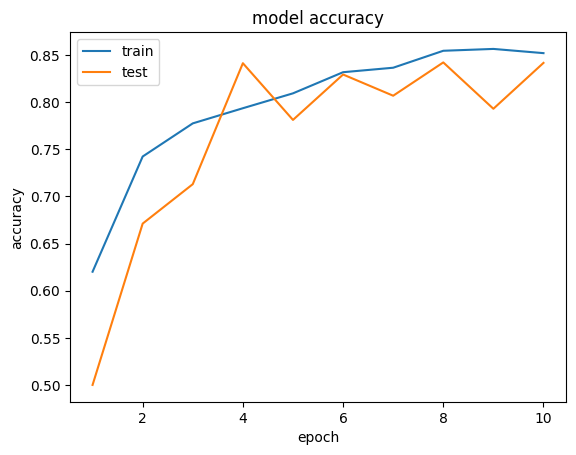

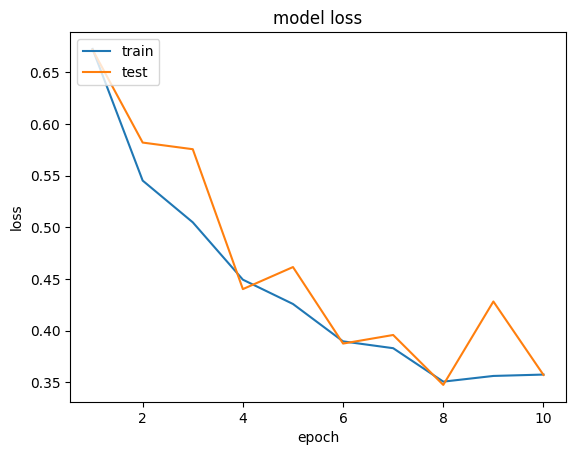

In [4]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MESO + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MESO + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MESO + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MESO + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LOAD DATA MOUTHNET (Regular Frame Generator)

In [5]:
import tensorflow as tf
from src.datagen import FrameGenerator

# CREATE TRAINING/TEST DATASETS

train_generator = FrameGenerator(TRAIN_PATH, FRAMES_PER_VIDEO_MOUTH, (IMG_SIZE, IMG_SIZE), training=True)
test_generator = FrameGenerator(TEST_PATH, FRAMES_PER_VIDEO_MOUTH, (IMG_SIZE, IMG_SIZE), training=False)
output_signature = (tf.TensorSpec(shape = (None, 256, 256, 3), dtype = tf.float32), tf.TensorSpec(shape = (1), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(train_generator,output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(test_generator,output_signature = output_signature)

# VERIFY DATA HAS CORRECT SHAPE
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Detected Labels:  {'fake': 0, 'real': 1}
Detected Labels:  {'fake': 0, 'real': 1}
Shape of training set of frames: (20, 256, 256, 3)
Shape of training labels: (1,)
Shape of validation set of frames: (20, 256, 256, 3)
Shape of validation labels: (1,)


### INITIALIZE/TRAIN/PLOT (Mouthnet Model)

In [6]:
from src.models import get_mouthnet_model
from src.helpers import save_history
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from time import perf_counter

# LOAD NEW MODEL
model = get_mouthnet_model()

# VERIFY MODEL
model.summary()

MODEL_NAME = "MOUTHNET_RegularFrame"

# INITIALIZE OPTIMIZER
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9, weight_decay=lr / EPOCHS_MOUTH)

start = perf_counter()

# COMPILE MODEL FOR TRAINING
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Saves the model whenever a new max val accuracy is reached
model_checkpoint_callback = ModelCheckpoint(
    filepath=f"saved_models/{MODEL_NAME}.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TRAIN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS_MOUTH,
    validation_data=test_ds,
    shuffle=True,
    callbacks=[model_checkpoint_callback]
)

print(f"TOTAL TRAIN TIME: {perf_counter() - start}")

# SAVE HISTORY TO FILE
save_history(history, MODEL_NAME)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 6, 6, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,078,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,414,881 (234.28 MB)

 Trainable params: 61,354,337 (234.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1176s 5s/step - accuracy: 0.4893 - loss: 0.7622 - val_accuracy: 0.5000 - val_loss: 0.6832
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1151s 5s/step - accuracy: 0.4737 - loss: 0.8159 - val_accuracy: 0.5000 - val_loss: 0.7592
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1211s 6s/step - accuracy: 0.5049 - loss: 0.8768 - val_accuracy: 0.5000 - val_loss: 0.6818
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1126s 5s/step - accuracy: 0.5913 - loss: 0.7724 - val_accuracy: 0.5000 - val_loss: 0.9026
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1375s 6s/step - accuracy: 0.4536 - loss: 0.8624 - val_accuracy: 0.5000 - val_loss: 0.7080
TOTAL TRAIN TIME: 6045.273404300213


### VISUALIZE TRAINING HISTORY

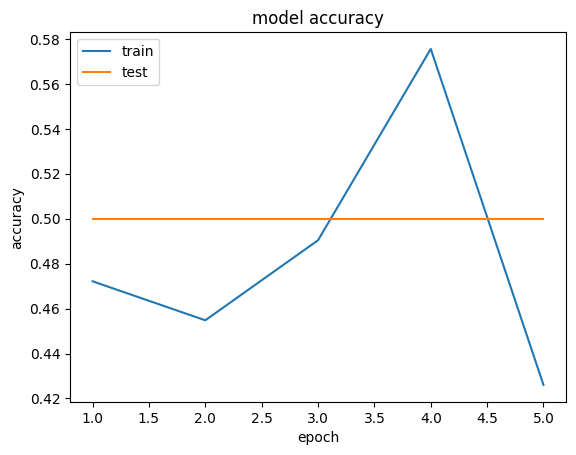

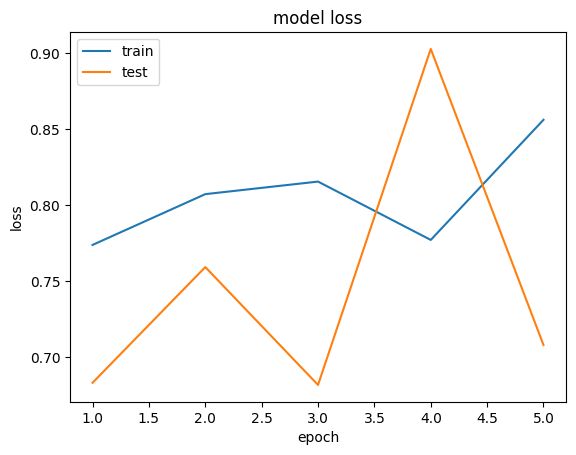

In [7]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib

# NOTE: ONLY WORKS FOR MULTIPLE EPOCHS

# PLOT ACCURACY
plt.plot(range(1, EPOCHS_MOUTH + 1), history.history['accuracy'])
plt.plot(range(1, EPOCHS_MOUTH + 1, 1),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# PLOT LOSS
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['loss'])
plt.plot(range(1, EPOCHS_MOUTH + 1),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()